In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt


import sklearn



# easiest way to install torch is using Anaconda via the python intall package manager -  pip - to use from the available CUDA from torch website

# conda create --name torch_env python=3.10 anaconda 
# conda activate torch_env
# conda install --upgrade pip

    # for CUDA 12.6  - (latest is 12.9)
# pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from torchsummary import summary

# Import updated PyTorch models with cleaned class names
from fMRINet_torch_updated import build_fmri_net, fmriNet8, fmriNet16, fmriNet32

In [2]:
# Load the DataFrame from the pickle file /-/ this is the toy dataframe ; for the actual data; please consider dataframe.pkl and get in touch with the author.


#{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
df = pd.read_pickle('dataframe.pkl')

df.head()


# #{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
# df = pd.read_pickle('toy_dataframe.pkl')

# df.head()

,Task,Time_Series_Data,subject,session
0,0,"[[1.9457951942054184, 2.1243432446451473, 2.24...",2755j,4
1,0,"[[2.0062126993459035, 1.1112578943817553, 2.87...",2755j,4
3,1,"[[3.1558751679308363, 1.7991844301841418, 2.59...",1043f,3
5,1,"[[1.779440351375669, 1.7387005028929754, 2.338...",4558a,1
7,2,"[[0.11108687476175652, 1.7908513499100132, 0.4...",4662a,8


In [3]:
# to work with the same train/validation splits while doing model development
with open('subjs.pickle', 'rb') as f:
    subjs = pickle.load(f)

# pull train/valid data by taking subjects from shuffled list
train_df = df[df['subject'].isin(subjs[0:45])]
valid_df = df[df['subject'].isin(subjs[45:,])]

# convert to numpy arrays and do reordering of data dimensions to feed into network
train_label = np.array(train_df['Task'])

train_data  = np.dstack(train_df['Time_Series_Data'])
train_data  = np.expand_dims(train_data, axis=0)
train_data  = np.transpose(train_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

valid_label = np.array(valid_df['Task'])

valid_data  = np.dstack(valid_df['Time_Series_Data'])
valid_data  = np.expand_dims(valid_data, axis=0)
valid_data  = np.transpose(valid_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

torch version 

In [4]:
import torch
import numpy as np

# assume these are your numpy arrays of class indices (shape (88, 6) and (19, 6))
# print("original numpy shapes:", train_label.shape, valid_label.shape)

num_classes = len(np.unique(train_label))  # should be 2

# ---- Torch conversion + one-hot ----
train_label_t = torch.from_numpy(train_label).long()              # (88, 6)
train_label_t = torch.nn.functional.one_hot(train_label_t,
                                            num_classes=num_classes).float()
# print("torch one-hot train_label:", train_label_t.shape)          # (88, 6, 2)

valid_label_t = torch.from_numpy(valid_label).long()              # (19, 6)
valid_label_t = torch.nn.functional.one_hot(valid_label_t,
                                            num_classes=num_classes).float()
# print("torch one-hot valid_label:", valid_label_t.shape)          # (19, 6, 2)


In [5]:
train_label_t

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])

In [6]:
train_label_t.shape

torch.Size([2846, 6])

In [7]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# train_label_t: torch tensor (N, 6), one-hot-like with exactly one 1 per row

# Collapse each row to a single class id 0..5
train_label_t2 = torch.argmax(train_label_t, dim=1)     # shape (N,)

# Compute unique class ids and their counts (like TF's a,b)
a, b = np.unique(train_label_t2.cpu().numpy(), return_counts=True)

# Compute class weights (balanced)
weights = compute_class_weight(
    class_weight='balanced',
    classes=a,
    y=train_label_t2.cpu().numpy()
)   # numpy array, same order as a

# Build a dict mapping class index → weight (just like TF)
class_weights = {int(cls): float(w) for cls, w in zip(a, weights)}

print("classes (a):", a)            # numpy array of class ids
print("counts  (b):", b)            # numpy array of counts per class
print("weights    :", weights)      # numpy array of balanced weights
print("class_weights dict:", class_weights)


classes (a): [0 1 2 3 4 5]
counts  (b): [364 539 382 519 835 207]
weights    : [1.30311355 0.88002474 1.2417103  0.91393706 0.56806387 2.29146538]
class_weights dict: {0: 1.3031135531135531, 1: 0.8800247371675943, 2: 1.2417102966841187, 3: 0.9139370584457289, 4: 0.568063872255489, 5: 2.2914653784219}


-----------

> the main formation we are applied with the tensorflow & keras, we are using same architecture and parameter amount on the total model protected on the torch side 

Tensorflow Architecture

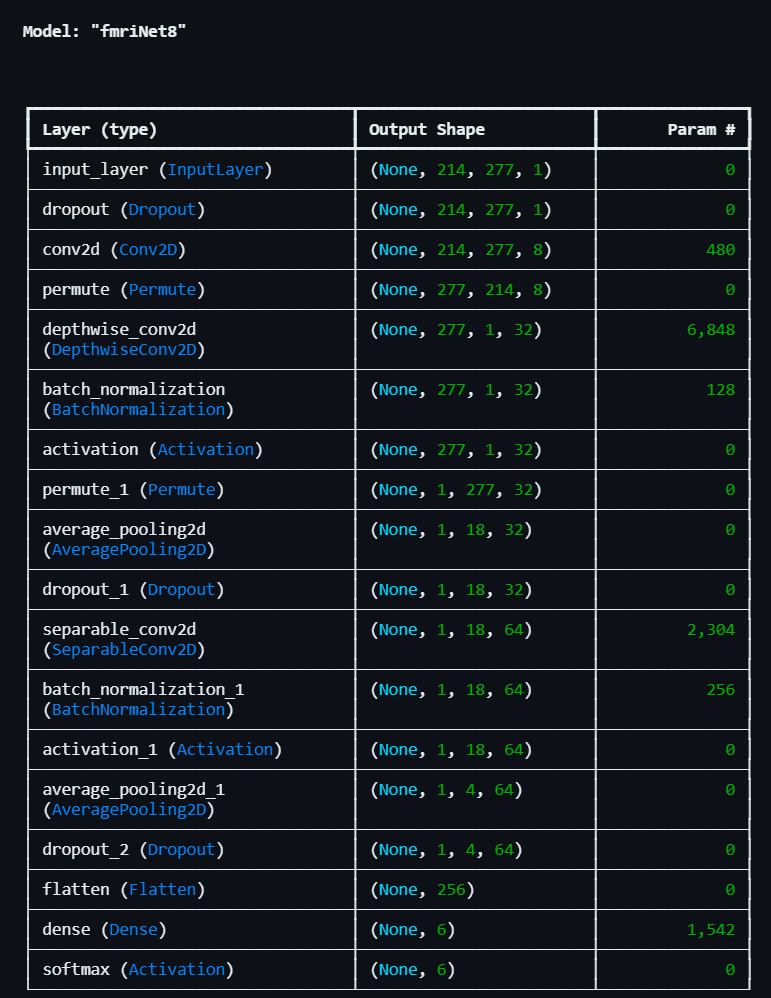

-------------

In [9]:
model = fmriNet8(num_classes=6, input_shape=(1, 214, 277), use_cuda=True, debug=False)


In [11]:
from torchsummary import summary
summary(model, input_size=(1, 214, 277))   # channel, height, width


Layer (type:depth-idx)                   Param #
├─Dropout: 1-1                           --
├─Conv2d: 1-2                            480
├─ConstrainedConv2d: 1-3                 6,848
├─BatchNorm2d: 1-4                       64
├─AvgPool2d: 1-5                         --
├─Dropout: 1-6                           --
├─Conv2d: 1-7                            256
├─Conv2d: 1-8                            2,048
├─BatchNorm2d: 1-9                       128
├─AvgPool2d: 1-10                        --
├─Dropout: 1-11                          --
├─Linear: 1-12                           1,542
Total params: 11,366
Trainable params: 11,366
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Dropout: 1-1                           --
├─Conv2d: 1-2                            480
├─ConstrainedConv2d: 1-3                 6,848
├─BatchNorm2d: 1-4                       64
├─AvgPool2d: 1-5                         --
├─Dropout: 1-6                           --
├─Conv2d: 1-7                            256
├─Conv2d: 1-8                            2,048
├─BatchNorm2d: 1-9                       128
├─AvgPool2d: 1-10                        --
├─Dropout: 1-11                          --
├─Linear: 1-12                           1,542
Total params: 11,366
Trainable params: 11,366
Non-trainable params: 0

In [12]:
# # Test that the new threshold is actually being used
# model = fmriNet8(num_classes=6, input_shape=(214,277,1), use_cuda=False, debug=False)

print("=== CHECKING ACTUAL THRESHOLD USED ===")
print(f"Constraint exists: {model.depthwise_conv.constraint is not None}")
if model.depthwise_conv.constraint:
    print(f"Actual threshold: {model.depthwise_conv.constraint.threshold}")
    print(f"Expected threshold: 1e-2 = {1e-2}")
    print(f"Match: {model.depthwise_conv.constraint.threshold == 1e-2}")

=== CHECKING ACTUAL THRESHOLD USED ===
Constraint exists: True
Actual threshold: 0.01
Expected threshold: 1e-2 = 0.01
Match: True


In [13]:

# PyTorch equivalent for model compilation and training setup
def setup_pytorch_training(model, device='cuda'):
    """
    PyTorch equivalent of TensorFlow's model.compile() and callbacks setup
    """
    
    # Move model to device
    model = model.to(device)
    
    # Loss function (equivalent to 'categorical_crossentropy')
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer (equivalent to AdamW with weight_decay=0.0005)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005)
    
    # Learning rate scheduler (equivalent to LearningRateScheduler)
    def lr_schedule(epoch):
        return 0.001 * np.power(0.5, np.floor(epoch/200))
    
    # Custom scheduler class
    class CustomLRScheduler:
        def __init__(self, optimizer, lr_schedule_func, verbose=1):
            self.optimizer = optimizer
            self.lr_schedule_func = lr_schedule_func
            self.verbose = verbose
            
        def step(self, epoch):
            new_lr = self.lr_schedule_func(epoch)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = new_lr
            if self.verbose:
                print(f"Epoch {epoch+1}: Learning rate: {new_lr:.6f}")
    
    scheduler = CustomLRScheduler(optimizer, lr_schedule, verbose=1)
    
    
    
    # Checkpoint saver (equivalent to ModelCheckpoint)
    class ModelCheckpoint:
        def __init__(self, filepath='/tmp/checkpoint.pth', verbose=1, save_best_only=True):
            self.filepath = filepath
            self.verbose = verbose
            self.save_best_only = save_best_only
            self.best_val_acc = 0.0
            
        def save(self, model, optimizer, epoch, val_acc):
            if self.save_best_only:
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_acc': val_acc,
                    }, self.filepath)
                    if self.verbose:
                        print(f"Epoch {epoch+1}: val_accuracy improved to {val_acc:.4f}, saving model to {self.filepath}")
                    return True
            else:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                }, self.filepath)
                if self.verbose:
                    print(f"Epoch {epoch+1}: saving model to {self.filepath}")
            return False
    
    checkpointer = ModelCheckpoint(filepath='./checkpoint.pth', verbose=1, save_best_only=True)
    
    return model, criterion, optimizer, scheduler, checkpointer


the exact same variation via the tf considered training architecture 



In [14]:
#### we will consider to fit the actual model and how we can going to train with mentioned setttings to the model archtiecture . . . .
# Setup training components using your existing function
model, criterion, optimizer, scheduler, checkpointer = setup_pytorch_training(model, device='cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch format
from torch.utils.data import DataLoader, TensorDataset

# Fix the data tensor conversion to match PyTorch format
# Convert labels to class indices (PyTorch CrossEntropyLoss needs indices, not one-hot)
train_label_indices = np.argmax(train_label_t, axis=1)
valid_label_indices = np.argmax(valid_label_t, axis=1)

# Convert to tensors in HWC format (batch, height, width, channels) for your new model
train_data_tensor = torch.FloatTensor(train_data).permute(0, 3, 1, 2)  # Keep original shape (batch, H, W, C)
train_label_tensor = torch.LongTensor(train_label_indices)
valid_data_tensor = torch.FloatTensor(valid_data).permute(0, 3, 1, 2)  # Keep original shape (batch, H, W, C)
valid_label_tensor = torch.LongTensor(valid_label_indices)

# Move to device
device = next(model.parameters()).device
train_data_tensor = train_data_tensor.to(device)
train_label_tensor = train_label_tensor.to(device)
valid_data_tensor = valid_data_tensor.to(device)
valid_label_tensor = valid_label_tensor.to(device)

print(f"Train data shape: {train_data_tensor.shape}")  # Should be (N, 214, 277, 1)
print(f"Valid data shape: {valid_data_tensor.shape}")  # Should be (N, 214, 277, 1)

# Verify the shapes match your model's expectations
H, W, C = model.input_shape
assert train_data_tensor.shape[1:] == (H, W, C), f"Train data shape mismatch: expected (N,{H},{W},{C}), got {train_data_tensor.shape}"
assert valid_data_tensor.shape[1:] == (H, W, C), f"Valid data shape mismatch: expected (N,{H},{W},{C}), got {valid_data_tensor.shape}"

# Create data loaders
train_dataset = TensorDataset(train_data_tensor, train_label_tensor)
valid_dataset = TensorDataset(valid_data_tensor, valid_label_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Setup class weights
weights = torch.FloatTensor([class_weights[i] for i in range(len(class_weights))]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights)

# Training history
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

print(f"Training on device: {device}")
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(valid_dataset)}")

# Training loop (equivalent to model.fit)
epochs = 400


for epoch in range(epochs):
    # Update learning rate
    if epoch % 200 == 0 and epoch > 0:
        scheduler.step(epoch)
    else:
        new_lr = 0.001 * np.power(0.5, np.floor(epoch/200))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)  # data is now in HWC format
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        train_total += target.size(0)
    
    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)  # data is now in HWC format
            loss = criterion(output, target)
            
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            val_correct += pred.eq(target.view_as(pred)).sum().item()
            val_total += target.size(0)
    
    # Calculate validation metrics
    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = val_correct / val_total
    
    # Save to history
    history['loss'].append(avg_train_loss)
    history['accuracy'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    # Save checkpoint
    checkpointer.save(model, optimizer, epoch, val_accuracy)
    
    # Print progress (verbose=2)
    print(f"Epoch {epoch+1}/{epochs} - "
          f"loss: {avg_train_loss:.4f} - accuracy: {train_accuracy:.4f} - "
          f"val_loss: {avg_val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

# Create history object
class fittedModel:
    def __init__(self, history_dict):
        self.history = history_dict

fittedModel = fittedModel(history)
print("Training completed!")

Train data shape: torch.Size([2846, 1, 214, 277])
Valid data shape: torch.Size([639, 1, 214, 277])
Training on device: cuda:0
Train samples: 2846, Validation samples: 639
Epoch 1: val_accuracy improved to 0.1847, saving model to ./checkpoint.pth
Epoch 1/400 - loss: 1.8355 - accuracy: 0.1665 - val_loss: 1.7828 - val_accuracy: 0.1847
Epoch 2: val_accuracy improved to 0.2754, saving model to ./checkpoint.pth
Epoch 2/400 - loss: 1.7967 - accuracy: 0.1824 - val_loss: 1.7629 - val_accuracy: 0.2754
Epoch 3: val_accuracy improved to 0.3474, saving model to ./checkpoint.pth
Epoch 3/400 - loss: 1.7521 - accuracy: 0.2186 - val_loss: 1.7012 - val_accuracy: 0.3474
Epoch 4: val_accuracy improved to 0.3709, saving model to ./checkpoint.pth
Epoch 4/400 - loss: 1.6791 - accuracy: 0.2730 - val_loss: 1.6190 - val_accuracy: 0.3709
Epoch 5/400 - loss: 1.5997 - accuracy: 0.3124 - val_loss: 1.5279 - val_accuracy: 0.3646
Epoch 6: val_accuracy improved to 0.5399, saving model to ./checkpoint.pth
Epoch 6/400 - 

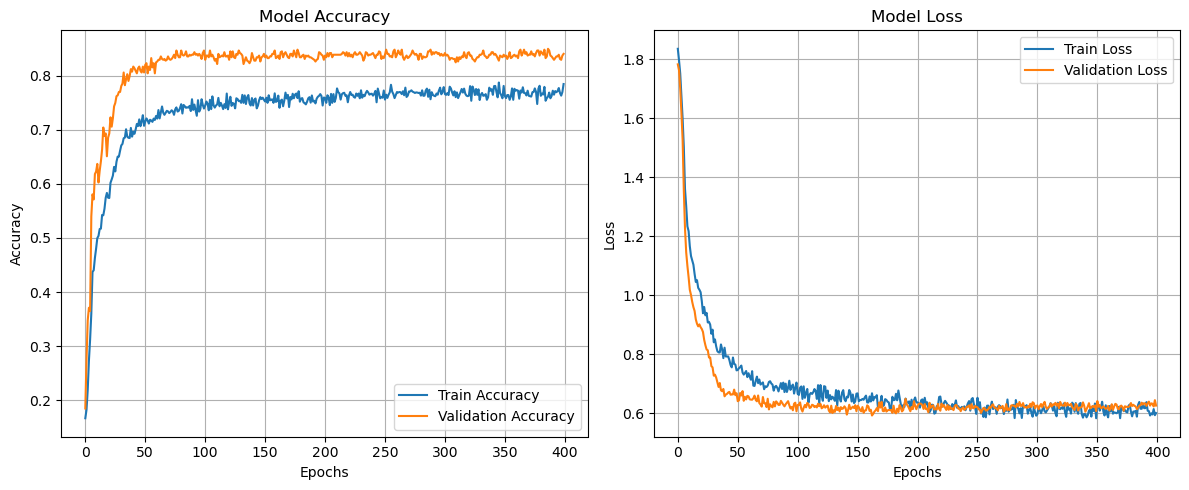

In [15]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(fittedModel.history['accuracy'], label='Train Accuracy')
plt.plot(fittedModel.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(fittedModel.history['loss'], label='Train Loss')
plt.plot(fittedModel.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

------------

In [17]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1️⃣ Recreate the model with the SAME constructor args as in training
model = fmriNet8(
    num_classes=6,
    input_shape=(1, 214, 277),
    depth_multiplier=4,
    zero_thresh=1e-2,
    dropout_in=0.25,
    dropout_mid=0.5,
    debug=False,
).to(device)

# 2️⃣ Load the checkpoint dict (weights_only=False if you trust this file)
checkpoint = torch.load('./checkpoint.pth', map_location=device, weights_only=False)

# 3️⃣ Restore model weights and (optionally) optimizer state
model.load_state_dict(checkpoint['model_state_dict'])
# if you need to resume training:
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 4️⃣ Switch to evaluation mode
model.eval()

# 5️⃣ Make predictions
with torch.no_grad():
    logits = model(valid_data_tensor.to(device))   # shape (B,6)
    preds = torch.softmax(logits, dim=1)           # probabilities like Keras .predict
    y_pred = preds.argmax(dim=1).cpu().numpy()     # predicted class indices

# y_true = valid_label_tensor.cpu().numpy()

# # 4️⃣ compute balanced accuracy
# bal_acc = balanced_accuracy_score(y_true, y_pred)
# print("Balanced accuracy:", bal_acc)


In [18]:
y_pred

array([0, 0, 1, 4, 1, 5, 4, 1, 5, 1, 4, 1, 3, 4, 3, 3, 2, 3, 4, 1, 3, 3,
       3, 2, 2, 4, 4, 1, 3, 3, 3, 1, 4, 4, 2, 2, 1, 1, 2, 2, 1, 1, 0, 0,
       5, 0, 0, 1, 4, 4, 5, 4, 3, 3, 3, 4, 3, 3, 3, 0, 0, 4, 4, 1, 4, 4,
       4, 1, 1, 4, 4, 4, 4, 1, 4, 1, 4, 5, 5, 4, 4, 5, 1, 1, 0, 2, 1, 0,
       2, 1, 4, 0, 1, 5, 2, 2, 3, 2, 5, 4, 2, 2, 1, 1, 2, 2, 4, 2, 2, 0,
       3, 3, 3, 4, 4, 3, 3, 3, 4, 5, 4, 2, 2, 5, 4, 1, 4, 4, 0, 2, 4, 1,
       5, 5, 2, 4, 4, 4, 1, 4, 4, 1, 0, 0, 0, 2, 4, 4, 4, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 4, 1, 2, 4, 4, 3, 3, 3, 2, 1, 2, 5, 3, 3, 3, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 5, 4, 4, 4, 1, 5, 4, 1, 4, 2, 3, 5, 3, 3, 3, 4,
       4, 0, 0, 1, 4, 4, 4, 3, 3, 2, 2, 4, 4, 1, 5, 4, 1, 4, 4, 1, 0, 2,
       4, 1, 5, 1, 1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 4, 0, 0, 4, 5, 1, 1, 4,
       3, 3, 3, 5, 4, 5, 2, 2, 0, 0, 1, 2, 2, 4, 5, 3, 3, 3, 1, 4, 2, 2,
       4, 0, 5, 2, 2, 4, 4, 2, 2, 3, 3, 3, 1, 4, 4, 1, 1, 4, 4, 4, 2, 2,
       4, 3, 3, 3, 4, 0, 0, 4, 0, 0, 0, 0, 0, 2, 4,

In [19]:
## predictions are predicted as a training and validation types (tensors are considdered with the information of the which type of the devide using for the processing )
preds

tensor([[8.3576e-01, 1.6075e-03, 1.4988e-01, 1.1249e-02, 1.4392e-03, 7.0686e-05],
        [8.5248e-01, 7.7325e-05, 4.5098e-02, 1.0189e-01, 4.4896e-04, 4.0358e-06],
        [2.3327e-02, 9.7305e-01, 7.1939e-04, 9.5530e-04, 1.9478e-03, 1.3588e-07],
        ...,
        [2.0566e-02, 1.9491e-02, 1.6417e-03, 1.4972e-02, 9.4320e-01, 1.2733e-04],
        [3.1949e-02, 1.2120e-04, 1.8257e-01, 8.6350e-04, 7.7537e-01, 9.1246e-03],
        [7.4788e-02, 8.0599e-01, 2.1062e-02, 1.0691e-02, 8.7208e-02, 2.5730e-04]],
       device='cuda:0')

> for the processing a torch tensor to the numpy if you working with the GPU not forget to remove the cpu consideration to work on this is the common problem of the when processing from torch to numpy 

In [20]:
# transform to predictions to numpy arrays from being torch tensors
preds = preds.cpu().numpy()

In [21]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(np.argmax(valid_label_t, axis=1), np.argmax(preds, axis=1))

0.8415246886060023

torch version

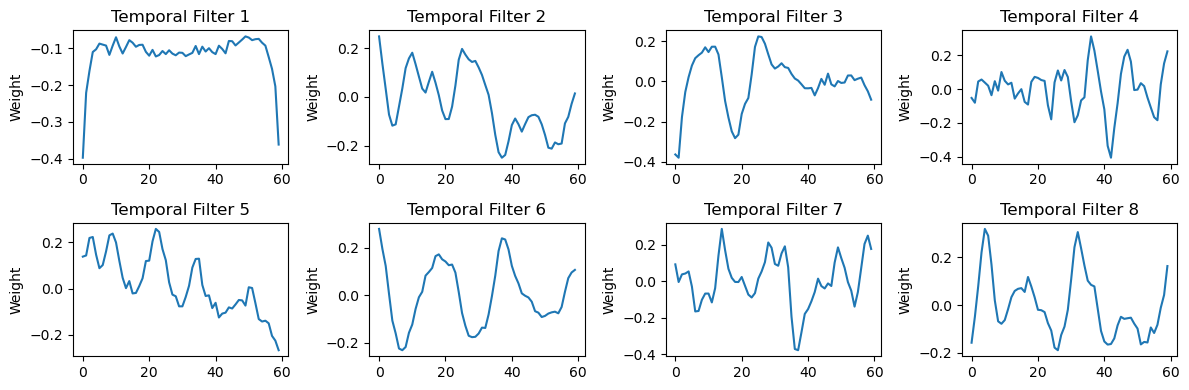

In [22]:
model.eval()
with torch.no_grad():
    # conv1: (out=8, in=1, kH=1, kW=60) -> we want 8 vectors of length 60
    w = model.conv1.weight.detach().cpu().numpy()        # (8, 1, 1, 60)
    w = w[:, 0, 0, :]                                     # (8, 60)

fig, axes = plt.subplots(2, 4, figsize=(12, 4))
axes = axes.ravel()

for i in range(8):
    axes[i].plot(w[i])
    axes[i].set_title(f"Temporal Filter {i+1}")
    axes[i].set_ylabel("Weight")

plt.tight_layout()
plt.show()

------------

reference spatial filters represented - (TF version)

In [23]:
### this will be removed but for the showing the previous filter very good representation to take a reference via the threshold changing 
# filters = np.squeeze(model.layers[4].get_weights())

# fig = plt.subplots(8, 4, figsize=(8, 12))

# i = 1
# for j in range(8):
#     for k in range(4):
#         plt.subplot(8, 4, i)
#         plt.plot(filters[:, j, k])
#         plt.title(f'T. Filter  {j+1}, S. Filter {k+1}')
#         i = i + 1
    
# plt.tight_layout()

------------------

Final weight shape: (214, 8, 4)


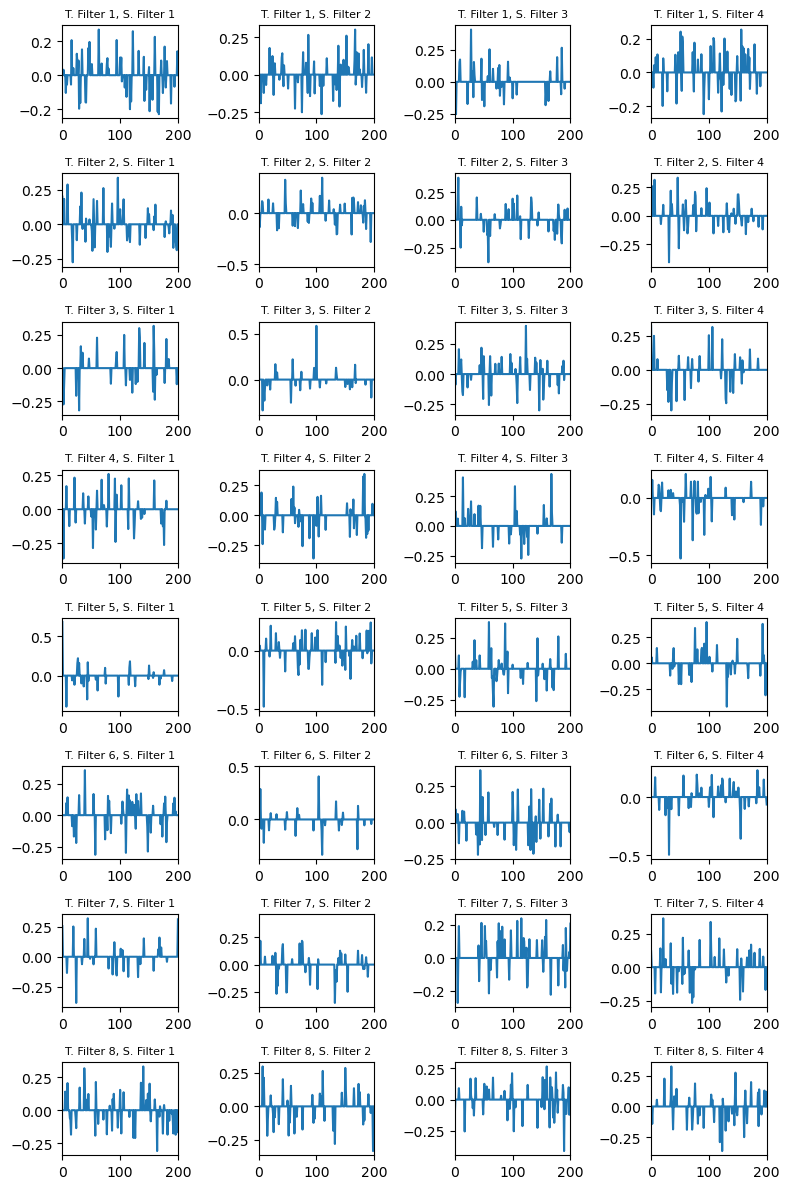

In [25]:
# Perfect visualization code - use Method 2
model.eval()
with torch.no_grad():
    # CHANGE: Remove .conv attribute - direct access to weights
    W = model.depthwise_conv.weight.detach().cpu().numpy()   # (32, 1, 214, 1)
    W = W[:, 0, :, 0]                                        # (32, 214)
    
    # Use Method 2: TensorFlow-like organization
    W = W.reshape(8, 4, 214).transpose(2, 0, 1)              # (214, 8, 4)
    
    print(f"Final weight shape: {W.shape}")  # Should be (214, 8, 4)

# Create visualization exactly like TensorFlow
fig, axes = plt.subplots(8, 4, figsize=(8, 12))

for j in range(8):  # temporal filter index
    for k in range(4):  # spatial filter index (depth multiplier)
        ax = axes[j, k]
        
        # Plot the spatial response: W[spatial_position, temporal_j, spatial_k]
        ax.plot(W[:201, j, k])  # Plot first 201 spatial positions
        ax.set_title(f"T. Filter {j+1}, S. Filter {k+1}", fontsize=8)
        ax.set_xlim(0, 200)
        ax.set_xticks([0, 100, 200])
        ax.grid(False)

plt.tight_layout()
plt.show()